In [64]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
ID = "03"
MODEL_NAME = "LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Close"
FRECUENCIA = "1H"
MSE_RESULT = 0

In [67]:
RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .05
VAL_SIZE = .15

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [68]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

EURUSD_ASK_1H_14F.csv
EURUSD_FULL_1D_20F.csv
EURUSD_FULL_1H_20F.csv
EURUSD_FULL_1M_20F.csv
EURUSD_FULL_4H_20F.csv


In [69]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

DATASET = pd.read_csv(filenames[2], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,day_name,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,2004-01-01 00:00:00,1.25950,1.25960,1.25826,1.25910,6654.2002,1.25934,1.25948,1.25814,1.25900,7823.1001,0.00010,Thursday,3,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,2004-01-01 01:00:00,1.25958,1.25960,1.25947,1.25951,660.6000,1.25942,1.25948,1.25934,1.25941,461.4000,0.00010,Thursday,3,0.000326,0.000326,0.000000,0.0,0.0,0.0
2,2004-01-01 02:00:00,1.25955,1.25962,1.25944,1.25951,2091.0000,1.25945,1.25948,1.25927,1.25936,1839.8000,0.00015,Thursday,3,0.000000,-0.000326,0.000000,0.0,0.0,0.0
3,2004-01-01 03:00:00,1.25950,1.25965,1.25834,1.25869,10003.0996,1.25934,1.25953,1.25821,1.25854,13349.2998,0.00015,Thursday,3,-0.000651,-0.000651,0.000000,0.0,0.0,0.0
4,2004-01-01 04:00:00,1.25908,1.25960,1.25843,1.25950,7603.3999,1.25898,1.25948,1.25829,1.25940,8422.5000,0.00010,Thursday,3,0.000644,0.001295,1.259262,0.0,0.0,0.0


In [70]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())

#Remove Day_name Column and Timestamp
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (102514, 20)
                Open           High            Low          Close  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean        1.264046       1.265085       1.263008       1.264047   
std         0.122828       0.123008       0.122629       0.122829   
min         1.035600       1.037040       1.034050       1.035630   
25%         1.149838       1.150705       1.149015       1.149833   
50%         1.270655       1.271820       1.269425       1.270670   
75%         1.350917       1.352038       1.349740       1.350920   
max         1.601460       1.604030       1.598830       1.601570   

              Volume       Open_Bid       High_Bid        Low_Bid  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean    20711.113359       1.263956       1.265001       1.262923   
std     32706.529958       0.122803       0.122983       0.122604   
min         0.380000       1.035580       1.037020       1.034030   
25%      498

In [71]:
#Remove first 200 rows because MA200 is 0
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(102315, 18)
      Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0  1.27584  1.27666  1.27351  1.27436  25980.0000   1.27580   1.27649   
1  1.27435  1.27891  1.27331  1.27891  24881.5996   1.27419   1.27884   
2  1.27890  1.27957  1.27550  1.27552  24909.9004   1.27880   1.27947   
3  1.27523  1.27566  1.27374  1.27462  26329.6992   1.27513   1.27555   
4  1.27465  1.27482  1.27195  1.27277  25984.5000   1.27449   1.27467   

   Low_Bid  Close_Bid  Volume_Bid   Spread  weekday  Pct_Range_Close  \
0  1.27341    1.27426  30272.0996  0.00010        1        -0.001176   
1  1.27318    1.27871  28934.9004  0.00020        1         0.003570   
2  1.27536    1.27538  32662.0000  0.00014        1        -0.002651   
3  1.27358    1.27452  31190.5996  0.00010        1        -0.000706   
4  1.27184    1.27262  32288.5996  0.00015        1        -0.001451   

   Pct_Range_Close_diff  MA_Close_5  MA_Close_25  MA_Close_50  MA_Close_200  
0             -0.001270    1.275586  

In [72]:
#Shape 
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  102315
Start:  0


In [73]:
#Shape the first START of the total and Number of Features
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

NUM_FEATURES = DF_Full.shape[1]
print("NUM_FEATURES = ",NUM_FEATURES)

(102315, 18)
NUM_FEATURES =  18


In [74]:
#VECTOR Y
TARGET_INDEX = DF_Full.columns.get_loc(TARGET_NAME)
print("index column: ",TARGET_INDEX)
print('VECTOR Y: ' + DF_Full[TARGET_NAME].name)
close_y = DF_Full[TARGET_NAME].iloc[1:]
close_y.columns = [TARGET_NAME+'_y']
print(close_y.head())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)

index column:  3
VECTOR Y: Close
1    1.27891
2    1.27552
3    1.27462
4    1.27277
5    1.27501
Name: Close, dtype: float64
(102314,)
102310    1.11071
102311    1.11141
102312    1.11123
102313    1.11158
102314    1.11158
Name: Close, dtype: float64
(102315,)


In [75]:
#Define INDEX for Subsets for Training, Testing and Validation

s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.2
count of Val and Test: 20463
end of train:  81852
count val:  15347
count test:  5115
end_val 97199


In [76]:
#Generate Subsets for Training, Testing and Validation
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print(data_training.shape)
print(data_val.shape)
print(data_test.shape)


#For Target Y Vector
data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]

print(data_training_y.shape)
print(data_val_y.shape)
print(data_test_y.shape)

(81852, 18)
(15347, 18)
(5116, 18)
(81852,)
(15347,)
(5116,)


In [77]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.42455731 0.42261768 0.4239881  ... 0.42897532 0.43233222 0.41469958]
 [0.42192415 0.42658601 0.42363398 ... 0.42846603 0.4325413  0.41488157]
 [0.42996501 0.42775005 0.4275116  ... 0.42751479 0.43266517 0.41502866]
 ...
 [0.03553883 0.03361611 0.0371295  ... 0.03336578 0.03448272 0.0430968 ]
 [0.03497331 0.03315755 0.03206558 ... 0.03273759 0.0340938  0.04289119]
 [0.03152723 0.03433923 0.03383618 ... 0.03236583 0.03383705 0.04270938]]


(81852, 18)


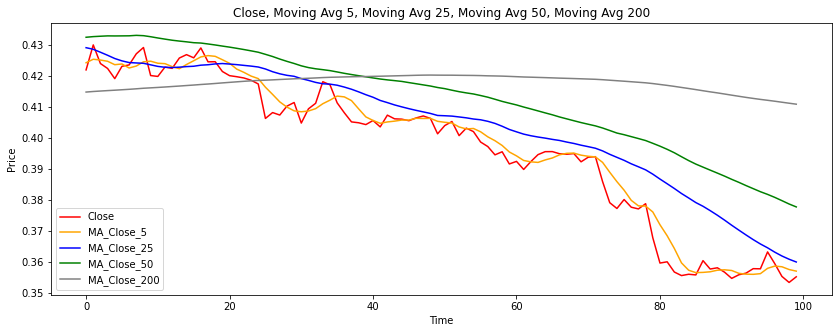

In [78]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(81852, 18)


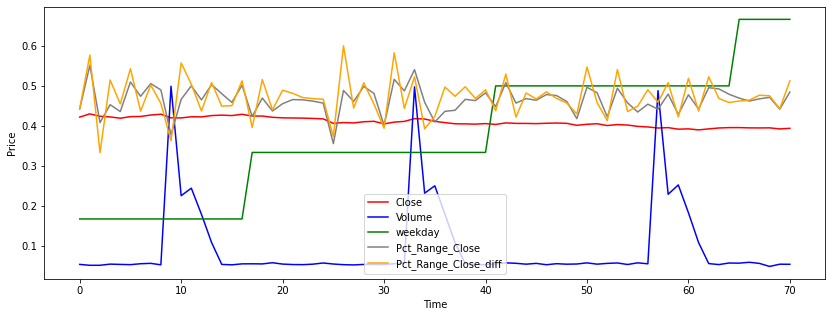

In [79]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 71


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(81852, 18)


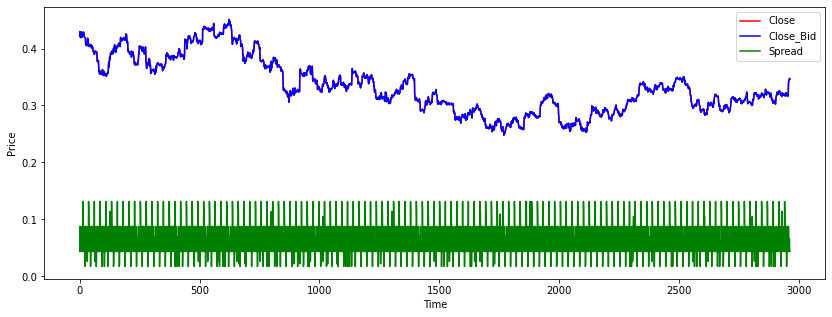

In [80]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 2963


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(81852, 18)


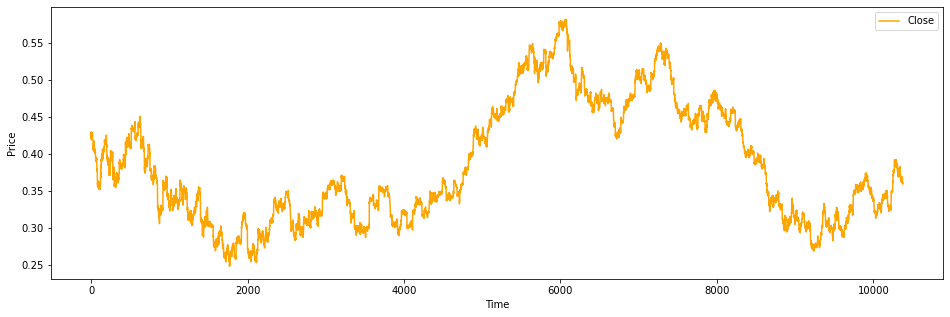

In [81]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 10377
plt.figure(figsize=(16,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX], color = 'orange', label = TARGET_NAME)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

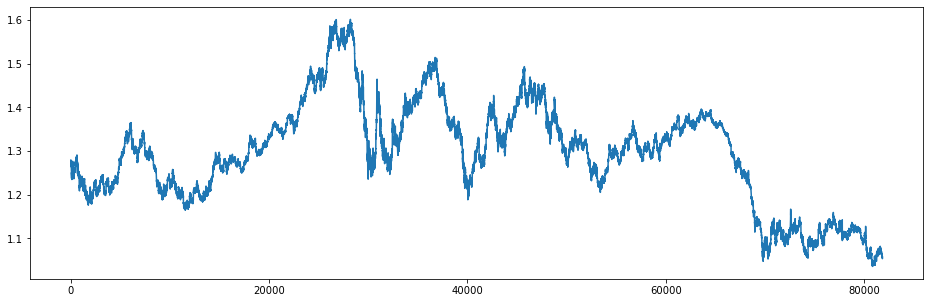

In [82]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [83]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(81801, 51, 18)
(81801,)


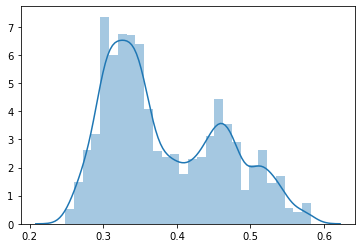

In [84]:
sns.distplot(data_training_array_scaled[INICIO:FIN,TARGET_INDEX]);


In [85]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 18)
(15347, 18)
<bound method NDFrame.head of           Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0      1.06416  1.06471  1.06301  1.06324   8647.0596   1.06413   1.06469   
1      1.06330  1.06335  1.06209  1.06238  13357.0898   1.06328   1.06334   
2      1.06238  1.06250  1.05999  1.06020  16731.0195   1.06237   1.06249   
3      1.06019  1.06078  1.05922  1.06044  16977.5996   1.06018   1.06076   
4      1.06045  1.06093  1.05942  1.06025  13403.8301   1.06044   1.06091   
...        ...      ...      ...      ...         ...       ...       ...   
15393  1.11081  1.11329  1.11068  1.11259  15711.2305   1.11079   1.11326   
15394  1.11259  1.11306  1.11194  1.11224  24315.7109   1.11258   1.11302   
15395  1.11221  1.11243  1.11122  1.11227  21284.8594   1.11219   1.11238   
15396  1.11227  1.11313  1.11226  1.11259  13567.6299   1.11223   1.11310   
15397  1.11258  1.11321  1.11235  1.11279   8872.3203   1.11255   1.11319   

       Low_Bid  Close_Bi

In [86]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(15347,)
0    1.06238
1    1.06020
2    1.06044
3    1.06025
4    1.05959
5    1.06034
6    1.05991
7    1.05959
8    1.05989
9    1.05964
Name: Close, dtype: float64


In [87]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.05047185 0.04880157 0.0512766  0.04878609 0.01758943 0.05046666
  0.0488119  0.05127842 0.04879816 0.01448656 0.00438596 0.
  0.44861456 0.44685172 0.04792438 0.04322989 0.04382942 0.0514492 ]
 [0.04895204 0.04640293 0.04964765 0.04726649 0.02717076 0.04896415
  0.0464304  0.04966712 0.04726052 0.02145942 0.00877193 0.
  0.45054703 0.47322715 0.04702109 0.0432084  0.04362395 0.05129577]
 [0.04732619 0.04490379 0.04592939 0.0434145  0.03403415 0.04735558
  0.04493094 0.04594872 0.04340756 0.02632076 0.00877193 0.
  0.4218963  0.44364924 0.04575861 0.04308305 0.04332567 0.0511327 ]
 [0.04345598 0.04187023 0.04456603 0.04383857 0.03453575 0.04348441
  0.04187909 0.0445676  0.04384942 0.03016703 0.00438596 0.
  0.47440568 0.52214157 0.04450324 0.04294982 0.0430458  0.05096963]
 [0.04391546 0.04213478 0.04492015 0.04350284 0.02726584 0.043944
  0.0421437  0.04492174 0.04347826 0.0216757  0.01315789 0.
  0.46505916 0.4623189  0.04310207 0.04279224 0.04281758 0.05079039]
 [0.04356201 0.04

In [88]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(15347, 51, 18)
(15347,)


In [89]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 18)
(5116, 18)


(5167, 18)

In [90]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(5116,)


(5167,)

In [91]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.05047185 0.04880157 0.0512766  0.04878609 0.01758943 0.05046666
  0.0488119  0.05127842 0.04879816 0.01448656 0.00438596 0.
  0.44861456 0.44685172 0.04792438 0.04322989 0.04382942 0.0514492 ]
 [0.04895204 0.04640293 0.04964765 0.04726649 0.02717076 0.04896415
  0.0464304  0.04966712 0.04726052 0.02145942 0.00877193 0.
  0.45054703 0.47322715 0.04702109 0.0432084  0.04362395 0.05129577]
 [0.04732619 0.04490379 0.04592939 0.0434145  0.03403415 0.04735558
  0.04493094 0.04594872 0.04340756 0.02632076 0.00877193 0.
  0.4218963  0.44364924 0.04575861 0.04308305 0.04332567 0.0511327 ]
 [0.04345598 0.04187023 0.04456603 0.04383857 0.03453575 0.04348441
  0.04187909 0.0445676  0.04384942 0.03016703 0.00438596 0.
  0.47440568 0.52214157 0.04450324 0.04294982 0.0430458  0.05096963]
 [0.04391546 0.04213478 0.04492015 0.04350284 0.02726584 0.043944
  0.0421437  0.04492174 0.04347826 0.0216757  0.01315789 0.
  0.46505916 0.4623189  0.04310207 0.04279224 0.04281758 0.05079039]
 [0.04356201 0.04

In [92]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(5116, 51, 18)
(5116,)


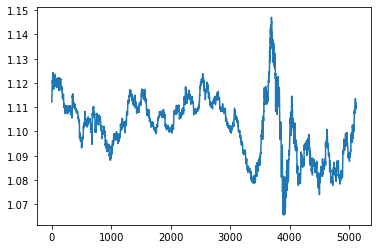

In [93]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

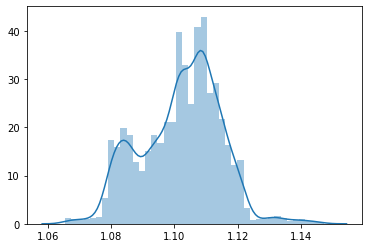

In [94]:
sns.distplot(y_test_np);


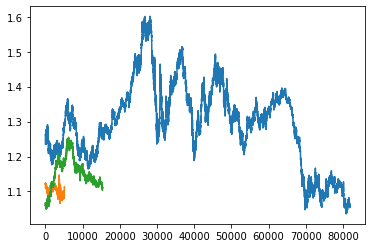

In [95]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [96]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
18


In [97]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
#regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))
regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))
regressior.add(Dense(units = 1))

In [98]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [99]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [100]:
regressior.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 51, 51)            14280     
_________________________________________________________________
lstm_6 (LSTM)                (None, 51, 80)            42240     
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
Total params: 153,121
Trainable params: 153,121
Non-trainable params: 0
_________________________________________________________________


In [101]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/


In [102]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [103]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Epoch 1/100
2557/2557 [==============================] - 285s 112ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 0.8901 - cosine_proximity: 0.9993 - val_loss: 1.8713e-05 - val_mean_squared_error: 1.8713e-05 - val_mean_absolute_error: 0.0037 - val_mean_absolute_percentage_error: 0.3191 - val_cosine_proximity: 1.0000
Epoch 2/100
2557/2557 [==============================] - 271s 106ms/step - loss: 4.2562e-05 - mean_squared_error: 4.2562e-05 - mean_absolute_error: 0.0051 - mean_absolute_percentage_error: 0.3911 - cosine_proximity: 1.0000 - val_loss: 1.4933e-05 - val_mean_squared_error: 1.4933e-05 - val_mean_absolute_error: 0.0034 - val_mean_absolute_percentage_error: 0.2904 - val_cosine_proximity: 1.0000
Epoch 3/100
2557/2557 [==============================] - 281s 110ms/step - loss: 4.8547e-05 - mean_squared_error: 4.8547e-05 - mean_absolute_error: 0.0055 - mean_absolute_percentage_error: 0.4218 - cosine_proximity: 1.0000

2557/2557 [==============================] - 271s 106ms/step - loss: 1.0783e-05 - mean_squared_error: 1.0783e-05 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 0.1905 - cosine_proximity: 1.0000 - val_loss: 2.1908e-06 - val_mean_squared_error: 2.1908e-06 - val_mean_absolute_error: 0.0010 - val_mean_absolute_percentage_error: 0.0896 - val_cosine_proximity: 1.0000
Epoch 22/100
2557/2557 [==============================] - 261s 102ms/step - loss: 1.0262e-05 - mean_squared_error: 1.0262e-05 - mean_absolute_error: 0.0024 - mean_absolute_percentage_error: 0.1842 - cosine_proximity: 1.0000 - val_loss: 5.8236e-06 - val_mean_squared_error: 5.8236e-06 - val_mean_absolute_error: 0.0021 - val_mean_absolute_percentage_error: 0.1798 - val_cosine_proximity: 1.0000
Epoch 23/100
2557/2557 [==============================] - 265s 103ms/step - loss: 1.1018e-05 - mean_squared_error: 1.1018e-05 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 0.1899 - cosine_proximity: 1.0000 -

2557/2557 [==============================] - 268s 105ms/step - loss: 8.8249e-06 - mean_squared_error: 8.8249e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1686 - cosine_proximity: 1.0000 - val_loss: 2.1671e-06 - val_mean_squared_error: 2.1671e-06 - val_mean_absolute_error: 0.0010 - val_mean_absolute_percentage_error: 0.0882 - val_cosine_proximity: 1.0000
Epoch 42/100
2557/2557 [==============================] - 267s 104ms/step - loss: 8.9032e-06 - mean_squared_error: 8.9032e-06 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 0.1702 - cosine_proximity: 1.0000 - val_loss: 2.5712e-06 - val_mean_squared_error: 2.5712e-06 - val_mean_absolute_error: 0.0012 - val_mean_absolute_percentage_error: 0.1006 - val_cosine_proximity: 1.0000
Epoch 43/100
2557/2557 [==============================] - 268s 105ms/step - loss: 8.3530e-06 - mean_squared_error: 8.3530e-06 - mean_absolute_error: 0.0021 - mean_absolute_percentage_error: 0.1626 - cosine_proximity: 1.0000 -

2557/2557 [==============================] - 268s 105ms/step - loss: 8.3366e-06 - mean_squared_error: 8.3366e-06 - mean_absolute_error: 0.0021 - mean_absolute_percentage_error: 0.1623 - cosine_proximity: 1.0000 - val_loss: 2.8733e-06 - val_mean_squared_error: 2.8733e-06 - val_mean_absolute_error: 0.0013 - val_mean_absolute_percentage_error: 0.1110 - val_cosine_proximity: 1.0000
Epoch 62/100
2557/2557 [==============================] - 265s 104ms/step - loss: 8.1001e-06 - mean_squared_error: 8.1001e-06 - mean_absolute_error: 0.0021 - mean_absolute_percentage_error: 0.1600 - cosine_proximity: 1.0000 - val_loss: 4.3629e-06 - val_mean_squared_error: 4.3629e-06 - val_mean_absolute_error: 0.0017 - val_mean_absolute_percentage_error: 0.1509 - val_cosine_proximity: 1.0000
Epoch 63/100
2557/2557 [==============================] - 262s 102ms/step - loss: 8.2269e-06 - mean_squared_error: 8.2269e-06 - mean_absolute_error: 0.0021 - mean_absolute_percentage_error: 0.1600 - cosine_proximity: 1.0000 -

2557/2557 [==============================] - 264s 103ms/step - loss: 7.9609e-06 - mean_squared_error: 7.9609e-06 - mean_absolute_error: 0.0020 - mean_absolute_percentage_error: 0.1575 - cosine_proximity: 1.0000 - val_loss: 6.7143e-06 - val_mean_squared_error: 6.7143e-06 - val_mean_absolute_error: 0.0023 - val_mean_absolute_percentage_error: 0.1983 - val_cosine_proximity: 1.0000
Epoch 82/100
2557/2557 [==============================] - 260s 102ms/step - loss: 7.8011e-06 - mean_squared_error: 7.8011e-06 - mean_absolute_error: 0.0020 - mean_absolute_percentage_error: 0.1555 - cosine_proximity: 1.0000 - val_loss: 2.0452e-06 - val_mean_squared_error: 2.0452e-06 - val_mean_absolute_error: 9.7399e-04 - val_mean_absolute_percentage_error: 0.0842 - val_cosine_proximity: 1.0000
Epoch 83/100
2557/2557 [==============================] - 262s 102ms/step - loss: 7.6980e-06 - mean_squared_error: 7.6980e-06 - mean_absolute_error: 0.0020 - mean_absolute_percentage_error: 0.1547 - cosine_proximity: 1.00

In [104]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)


LSTM_1H_18F_Close_03.hdf5


In [105]:
regressior.save(source_data + file_name)

In [106]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity'])


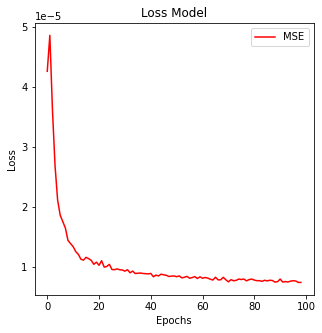

In [107]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

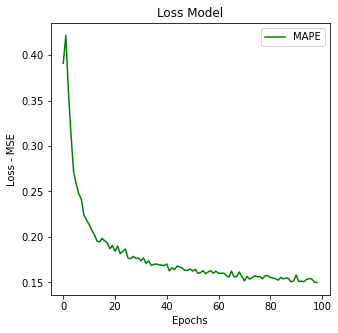

In [108]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][1:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [109]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models\../../../Models/2020/LSTM/LSTM_1H_18F_Close_03.hdf5


In [110]:
X_test_np.shape

(5116, 51, 18)

In [111]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape



(5116, 1)

In [112]:
numpy_data = np.array(y_test_pred)
yhat = pd.DataFrame(data=numpy_data, columns=["Prediction"])
print(yhat)
#data_test['prediction'] = yhat
#print(data_test.tail)

      Prediction
0       1.055685
1       1.076047
2       1.090503
3       1.099639
4       1.106318
...          ...
5111    1.109249
5112    1.109289
5113    1.109774
5114    1.110777
5115    1.110816

[5116 rows x 1 columns]


In [113]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape


(81801, 1)

(5116,)
(5116, 1)


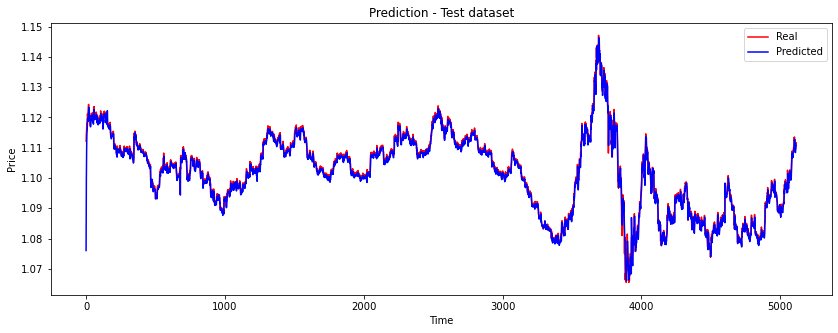

In [114]:
INICIO = 0
FIN = 20463
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN][1:], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [115]:
print(data_test.head)

<bound method NDFrame.head of            Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
97199   1.11278  1.11313  1.11239  1.11259  12341.6602   1.11276   1.11310   
97200   1.11256  1.11312  1.11172  1.11217  22242.2500   1.11254   1.11310   
97201   1.11217  1.11357  1.11143  1.11303  32390.7793   1.11213   1.11353   
97202   1.11303  1.11477  1.11298  1.11469  26491.7109   1.11301   1.11475   
97203   1.11468  1.11548  1.11419  1.11490  28911.1191   1.11466   1.11544   
...         ...      ...      ...      ...         ...       ...       ...   
102310  1.10998  1.11070  1.10862  1.10998  12120.8398   1.10995   1.11066   
102311  1.10997  1.11094  1.10982  1.11071   4646.7427   1.10993   1.11085   
102312  1.11213  1.11217  1.11136  1.11141    417.4906   1.11129   1.11194   
102313  1.11138  1.11148  1.11028  1.11123   4549.1167   1.11130   1.11144   
102314  1.11123  1.11199  1.11119  1.11158   5159.8101   1.11119   1.11195   

        Low_Bid  Close_Bid  Volum

In [116]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [117]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


Test MAE: 0.0011318820226667815
Test RMSE: 0.0019365160380621488
Test MSE: 3.7500943656719217e-06
Test MAPE: 1.2779584191749964


(81801,)
(81801, 1)


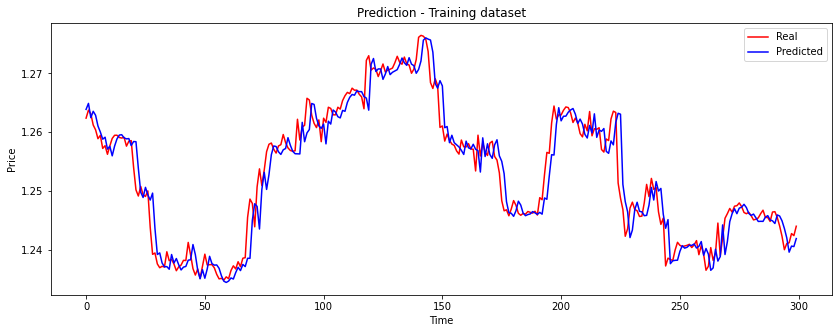

In [118]:
INICIO = 0
FIN = 300
print(y_train_np.shape)
print(y_train_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN][:], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [119]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
#print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error


Train MAE: 0.0015795244956191708
Train RMSE: 0.0023992246230426406
Train MSE: 5.756278791814101e-06
